Imports

In [1]:
import random

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

import gymnasium as gym

from stable_baselines3 import A2C,PPO


from stable_baselines3.common.logger import configure


import fabian.envs.khazad_dum_gymn 

import matplotlib.pyplot as plt

import pickle

## Working with 26May_TestingPseudoRoML_A2C_3a_MAML

Load in returns generated from the final form of this model

In [2]:
model_save_path = "C:\\Users\\fabia\\Documents\\GitHub\\MetaStableBaselines3\\proj_code\\saved_models\\26May_TestingPseudoRoML_A2C_3a"

dbfile = open(f"{model_save_path}\\iidReturnList.pickle", 'rb')
return_list = pickle.load(dbfile)

dbfile = open(f"{model_save_path}\\TaskwiseReturns.pickle", 'rb')
returns=pickle.load(dbfile) 

In [3]:
print(len(return_list))
print(len(returns.keys()))

100001
100


Load in the model too, to have access to the SMC functions of it

In [4]:
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1") # can access wrapped env with "env.unwrapped" (e.g. to reset task)
env.unwrapped.exp_bonus = 1; env.unwrapped.bridge_bonus_factor = 2 #this should incentivise getting to the target asap, and incentivise going onto the bridge


meta_agent = A2C("MlpPolicy", env, verbose=0, learning_rate=7e-4, device="cpu",
                 meta_learning=True, M=1, adapt_timesteps=4*32, eval_timesteps=2*32)
meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\final", weights_only=True))

c:\Users\fabia\anaconda3\envs\projdist\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


<All keys matched successfully>

Histogram of i.i.d. returns

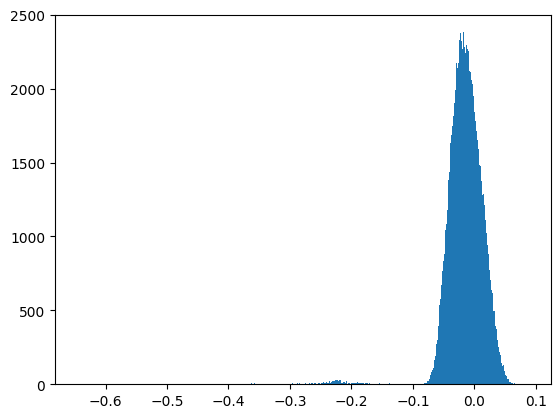

In [5]:
plt.hist([i[0] for i in return_list], bins="auto")
plt.show()

Theorem 1

In [6]:
return_list_sorted = sorted(return_list)

In [7]:
eta=0.001
k=int(len(return_list_sorted)*0.05)

epsilon, guarantee =  meta_agent.rollout_risk_SMC(eta, k, return_list_sorted)
print((epsilon, guarantee))


(array([0.05216458]), [tensor(-0.0531)])


In [ ]:
for k in range(0,int(np.ceil(0.02*tasks))):
    epsilon, guarantee =  meta_agent.rollout_risk_SMC(eta, k, return_list)
    print((epsilon, guarantee))

Theorem 2 c2

In [9]:
a=-1-3*(1)
b=5/env.unwrapped.normalize_rewards + 1 + env.unwrapped.bridge_bonus_factor*env.unwrapped.exp_bonus
print(f"(a,b) = {(a,b)}")

(a,b) = (-4, 3.15625)


In [12]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (-0.6,0.2)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))




  0%|          | 0/101 [00:00<?, ?it/s]

C:\Users\fabia\Documents\GitHub\MetaStableBaselines3\proj_code\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:552: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  epsilon = fsolve(self._theorem2_epsiloneq, starting_point, args=(k,K,n,gamma,eta))
100%|██████████| 101/101 [01:00<00:00,  1.66it/s]

(array([0.01273097]), np.float64(-0.2054250631712344))


In [13]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (a,b)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

100%|██████████| 101/101 [01:15<00:00,  1.35it/s]

(array([0.01273097]), np.float64(-1.5694547186314007))


In [14]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (-0.6,0.2)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

  0%|          | 0/101 [00:00<?, ?it/s]C:\Users\fabia\Documents\GitHub\MetaStableBaselines3\proj_code\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:552: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  epsilon = fsolve(self._theorem2_epsiloneq, starting_point, args=(k,K,n,gamma,eta))
 96%|█████████▌| 97/101 [01:20<00:03,  1.20it/s]

(array([0.1171632]), np.float64(-0.2054250631712344))


In [15]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (a,b)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

 96%|█████████▌| 97/101 [01:06<00:02,  1.46it/s]

(array([0.1171632]), np.float64(-1.5694547186314007))


Theorem 2 c3

In [16]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0



epsilon, guarantee =  meta_agent.task_risk_SMC_c3(gamma, eta, k, [i[0] for i in return_list_sorted], returns)
print((epsilon, guarantee))

gamma_2=0.022512147630450167


100%|██████████| 101/101 [01:05<00:00,  1.55it/s]

(array([0.02632269]), tensor(-0.1911))


In [17]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0



epsilon, guarantee =  meta_agent.task_risk_SMC_c3(gamma, eta, k, [i[0] for i in return_list_sorted], returns)
print((epsilon, guarantee))

gamma_2=0.022512147630450167


 94%|█████████▍| 95/101 [00:50<00:03,  1.88it/s]

(array([0.15606601]), tensor(-0.1911))
